<a href="https://colab.research.google.com/github/hasibzunair/neuralwhat/blob/master/malaria_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

In [19]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [0]:
!cp kaggle.json ~/.kaggle/

In [10]:
!kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
mohansacharya/graduate-admissions                             Graduate Admissions                                   9KB  2018-12-28 10:07:14           3437  
karangadiya/fifa19                                            FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59           2858  
xvivancos/barcelona-data-sets                                 Barcelona data sets                                   1MB  2018-12-13 14:16:53            789  
lava18/google-play-store-apps                                 Google Play Store Apps                                2MB  2018-09-18 20:49:49          31973  
timoboz/stock-data-dow-jones                        

In [12]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 336M/337M [00:08<00:00, 46.7MB/s]
100% 337M/337M [00:08<00:00, 40.6MB/s]


In [13]:
!ls

cell-images-for-detecting-malaria.zip  kaggle.json  sample_data


In [14]:
os.listdir()

['.config',
 'kaggle.json',
 'cell-images-for-detecting-malaria.zip',
 'sample_data']

In [16]:
!unzip 'cell-images-for-detecting-malaria.zip'

Archive:  cell-images-for-detecting-malaria.zip
   creating: cell_images/
   creating: cell_images/Parasitized/
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png  
 extracting: cell_images/Parasitized/C

In [17]:
!ls

cell_images  cell-images-for-detecting-malaria.zip  kaggle.json  sample_data


In [20]:
PATH = "cell_images"
print(os.listdir(PATH))

['Uninfected', 'Parasitized']


In [21]:
# all image path of parasitized
paths_para=glob.glob(os.path.join(PATH,'Parasitized','*.png'))
paths_uninf=glob.glob(os.path.join(PATH,'Uninfected','*.png'))
len(paths_para), len(paths_uninf)

(13779, 13779)

In [22]:
# show one
path=paths_para[0]
img=cv2.imread(path) # cv2 stores image in BGR format
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # transforming to RGB format
img.shape

(142, 136, 3)

In [0]:
# helper to get images
def get_data(path, resize_dim=96):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

In [24]:
parasite_images=np.array([get_data(path) for path in paths_para])
parasite_images.shape

(13779, 96, 96, 3)

In [25]:
uninf_images=np.array([get_data(path) for path in paths_uninf])
uninf_images.shape

(13779, 96, 96, 3)

In [26]:
para_label = np.array([1 for _ in range(len(parasite_images))])
uninf_label = np.array([0 for _ in range(len(uninf_images))])

para_label.shape, uninf_label.shape

((13779,), (13779,))

In [85]:
x_all = np.concatenate((parasite_images, uninf_images), axis=0)
y_all = np.concatenate((para_label, uninf_label), axis=0)
print(x_all.shape, y_all.shape)

#train = shuffle(train, random_state=123)

(27558, 96, 96, 3) (27558,)


Index number: 3138
Label: 1


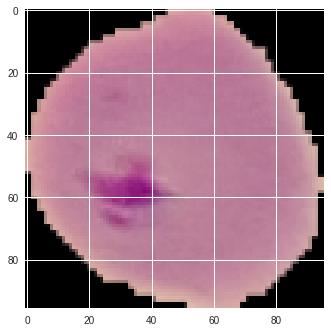

In [86]:
idx = random.randint(0, len(x_all))
print("Index number: {}".format(idx))
print("Label: {}".format(y_all[idx]))
plt.imshow(x_all[idx])

In [0]:
indices=list(range(len(x_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.95)
# train data
input_features=x_all[indices[:ind]] 
labels=y_all[indices[:ind]]
# validation data
x_test=x_all[indices[-(len(indices)-ind):]] 
y_test=y_all[indices[-(len(indices)-ind):]]

In [88]:
print(input_features.shape, labels.shape)
print(x_test.shape, y_test.shape)


(26180, 96, 96, 3) (26180,)
(1378, 96, 96, 3) (1378,)


In [89]:
x_train, x_val, y_train, y_val = train_test_split(input_features, labels, test_size=0.1, random_state=1)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(23562, 96, 96, 3) (2618, 96, 96, 3) (23562,) (2618,)


In [90]:
# one hot encoded vectors
num_classes = 2

y_train = np_utils.to_categorical(y_train,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
print(y_train.shape, y_val.shape, y_test.shape)

(23562, 2) (2618, 2) (1378, 2)


In [33]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(23562, 96, 96, 3) (23562, 2) (2618, 96, 96, 3) (2618, 2)


# Data loaded!

In [46]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((23562, 96, 96, 3), (23562, 2), (2618, 96, 96, 3), (2618, 2))

In [47]:
x_test.shape, y_test.shape

((1378, 96, 96, 3), (1378, 2))

# Model

In [0]:
IMAGE_SIZE = 96
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 32

In [0]:
def normal():
  input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
  model = Sequential()
  model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
  model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
  model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
  model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
  model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(2))
  model.add(Activation('softmax'))

  model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])
  return model

In [62]:
naive = normal()
naive.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 3..., activation="relu", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 24, 24, 128)       73856     
__________

In [64]:
model=normal()
path_model='normal.h5'  

# set the learning rate
K.set_value(model.optimizer.lr,1e-4) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=BATCH_SIZE, 
            epochs=EPOCHS, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 3..., activation="relu", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")

Train on 23562 samples, validate on 2618 samples
Epoch 1/20
23562/23562 [==============================] - 51s 2ms/step - loss: 0.4901 - acc: 0.7352 - val_loss: 0.1424 - val_acc: 0.9603
Epoch 2/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1628 - acc: 0.9500 - val_loss: 0.1225 - val_acc: 0.9595
Epoch 3/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1472 - acc: 0.9551 - val_loss: 0.1245 - val_acc: 0.9660
Epoch 4/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1400 - acc: 0.9572 - val_loss: 0.1090 - val_acc: 0.9633
Epoch 5/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1334 - acc: 0.9585 - val_loss: 0.1449 - val_acc: 0.9610
Epoch 6/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1338 - acc: 0.9568 - val_loss: 0.1140 - val_acc: 0.9649
Epoch 7/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1331 - acc: 0.9581 - val_loss: 0.2234 - val_acc:

In [0]:
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()

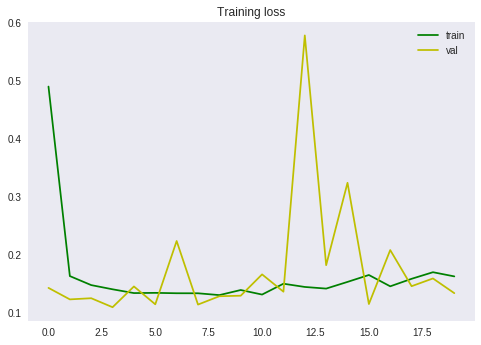

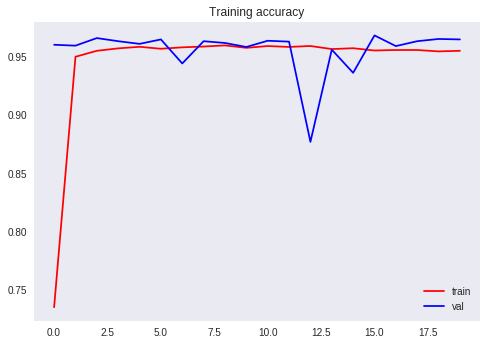

In [91]:
plot_loss_accu(h)

In [92]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14769750153334982
Test accuracy: 0.9658925979680697


# Using model.predict(test)

In [95]:
y_pred = model.predict(x_test)
y_pred.shape

(1378, 2)

In [0]:
#y_pred = np.array([(y[0]>=0.5).astype(np.uint8) for y in y_pred])
#y_pred.shape

In [97]:
labels = np.array([np.argmax(pred) for pred in y_pred])
labels.shape

(1378,)

In [98]:
#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
y_test.shape

(1378,)

In [99]:
y_test.shape, labels.shape

((1378,), (1378,))

In [101]:
print('Accuracy: ',np.mean((y_test==labels)))

Accuracy:  0.9658925979680697
